In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, v2
from torchmetrics.classification import MultilabelAccuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, MeanMetric

%config InlineBackend.figure_format='retina'

In [119]:
device = torch.device("mps")
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [120]:
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file  (str): Path to the CSV file with annotations.
            img_dir   (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # If you like, you can store the columns referencing labels:
        # (Assuming the first column is 'filename', and the rest are labels)
        self.label_columns = self.dataframe.columns[1:]  # piano -> other

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 1) Get row from dataframe
        row = self.dataframe.iloc[idx]

        # 2) Construct image path
        img_path = os.path.join(self.img_dir, row['filename'])

        # 3) Open and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        # 4) Build multi-hot label vector
        #    Extract columns piano, guitar, bass, brass, strings, other
        label_values = row[self.label_columns].values.astype('float32')
        # label_values is shape (6,) -> e.g. [1,0,1,0,1,0]

        # Convert to a PyTorch tensor
        labels = torch.tensor(label_values, dtype=torch.float32)

        return image, labels

In [121]:
class AddPixelwiseNoise(object):
    def __init__(self, std=0.02, clamp=True):
        self.std = std
        self.clamp = clamp

    def __call__(self, img_tensor):
        # img_tensor in [0,1], shape [channels, height, width]
        noise = torch.randn_like(img_tensor) * self.std
        noised_img = img_tensor + noise
        if self.clamp:
            noised_img = torch.clamp(noised_img, 0.0, 1.0)
        return noised_img
    
# Define transforms
transform = transforms.Compose([
    # 1) Crop out edges (CenterCrop or RandomCrop), e.g. 800x800 from 1000x2000
    transforms.RandomCrop((2000, 700)),
    transforms.Resize((400, 280)),
    transforms.ToTensor(),
    AddPixelwiseNoise(std=0.05),
])

# Load entire dataset
# full_dataset = datasets.ImageFolder(root='dataset_root', transform=transform)
full_dataset = MultiLabelDataset(
    csv_file='data/labels.csv',
    img_dir='data/spectrograms',
    transform=transform
)

# Define split ratios (e.g., 70% train, 15% val, 15% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Compute lengths
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(42))  # fixed seed for reproducibility

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mapping
class_names = ["piano", "bass", "drums", "guitar", "synth"]
num_classes = len(class_names)

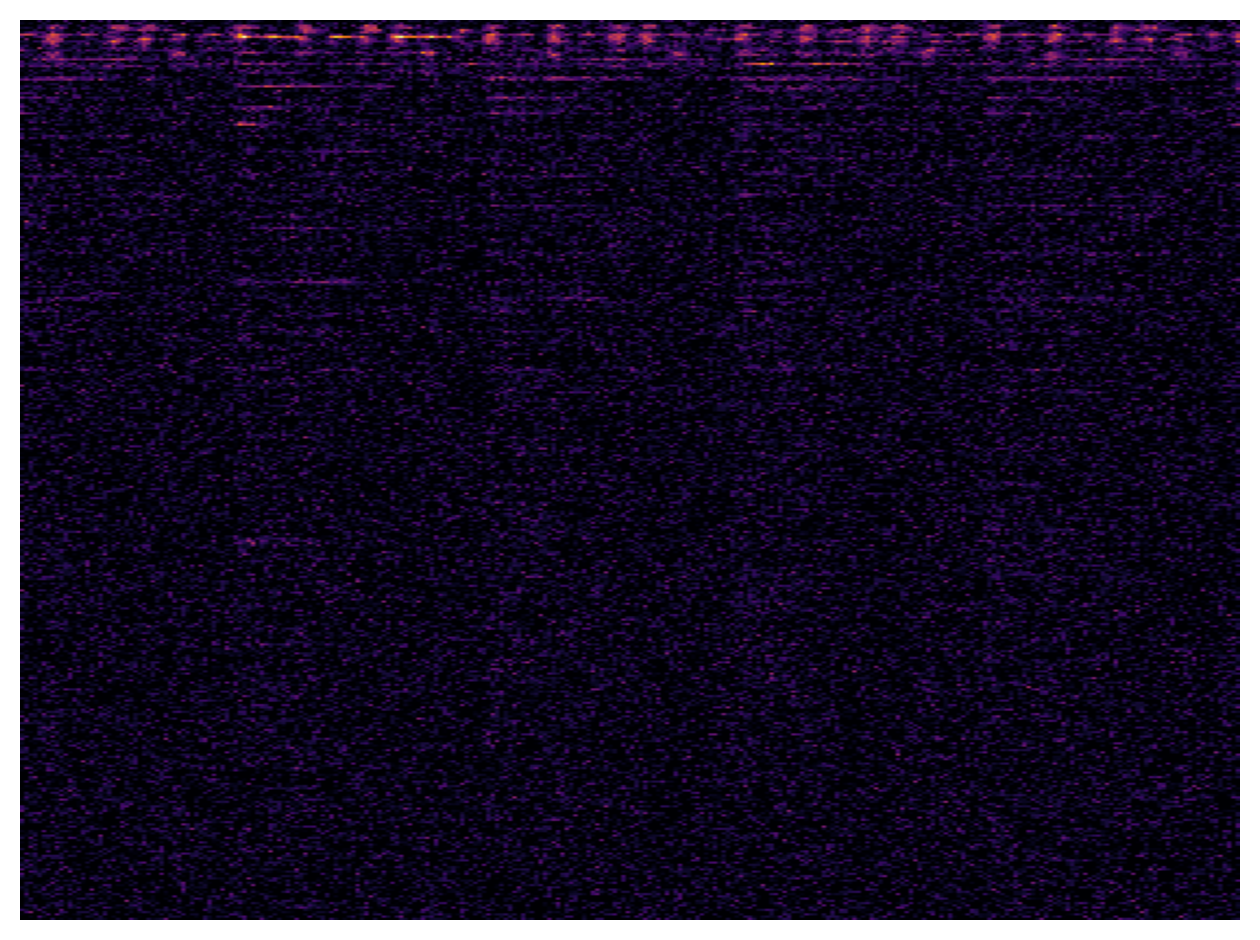

In [122]:
for X, y in train_dataloader:
   img =plt.imshow(X[0][0], aspect="auto", cmap="inferno", )
   plt.axis('off')
   plt.tight_layout()
   break
   

In [123]:
# Define model
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [124]:
model = model.to(device)

optimiser = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
criteria = nn.BCEWithLogitsLoss()

train_loss = MeanMetric().to(device)
epochs = 50

In [125]:
# a function for training one epoch
def train_one_epoch():
   # Prepare for storing loss and accuracy
   losses = MeanMetric().to(device)
   acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5).to(device)
   model.train()
   for X, Y in train_dataloader:
      X = X.to(device) 
      Y = Y.to(device)
      optimiser.zero_grad()
      logits = model(X)
      loss = criteria(logits, Y)
      loss.backward()
      optimiser.step() 
      losses.update(loss, X.size(0))
      probs = torch.sigmoid(logits)
      acc.update(probs, Y)
   return losses.compute() .item(), acc.compute().item()

In [126]:
# a function for validation one epoch
def validation_one_epoch():
   losses = MeanMetric().to(device)
   acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5).to(device)
   model.eval()

   for X, Y in val_dataloader:
      X = X.to(device) 
      Y = Y.to(device) 
      logits = model(X)
      loss = criteria(logits, Y)
      losses.update(loss, X.size(0)) 
      probs = torch.sigmoid(logits)
      acc.update(probs, Y)

   return losses.compute().item(), acc.compute().item()

In [127]:
for i in range(epochs):
   train_loss, train_acc = train_one_epoch() # training
   val_loss, val_acc = validation_one_epoch() # validation
   print("Epoch:", i, "| Train Loss:", round(train_loss, 3), "| Train Accuracy", round(train_acc, 3),
            "| Validation Loss", round(val_loss, 3), "| Validation Accuracy", round(val_acc, 3))

Epoch: 0 | Train Loss: 0.49 | Train Accuracy 0.756 | Validation Loss 0.886 | Validation Accuracy 0.513
Epoch: 1 | Train Loss: 0.42 | Train Accuracy 0.8 | Validation Loss 0.636 | Validation Accuracy 0.71
Epoch: 2 | Train Loss: 0.384 | Train Accuracy 0.816 | Validation Loss 0.549 | Validation Accuracy 0.697
Epoch: 3 | Train Loss: 0.344 | Train Accuracy 0.831 | Validation Loss 0.738 | Validation Accuracy 0.682
Epoch: 4 | Train Loss: 0.329 | Train Accuracy 0.842 | Validation Loss 0.822 | Validation Accuracy 0.734
Epoch: 5 | Train Loss: 0.291 | Train Accuracy 0.861 | Validation Loss 0.647 | Validation Accuracy 0.709
Epoch: 6 | Train Loss: 0.288 | Train Accuracy 0.859 | Validation Loss 0.972 | Validation Accuracy 0.685
Epoch: 7 | Train Loss: 0.287 | Train Accuracy 0.866 | Validation Loss 0.516 | Validation Accuracy 0.765
Epoch: 8 | Train Loss: 0.251 | Train Accuracy 0.884 | Validation Loss 0.835 | Validation Accuracy 0.776
Epoch: 9 | Train Loss: 0.237 | Train Accuracy 0.89 | Validation Loss 

RuntimeError: MPS backend out of memory (MPS allocated: 4.10 GB, other allocations: 4.77 GB, max allowed: 9.07 GB). Tried to allocate 218.75 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [192]:
from torchmetrics.classification import MultilabelConfusionMatrix, MultilabelAccuracy, MultilabelAUROC

# Create multi-label confusion matrix & accuracy objects
test_confusion_matrix = MultilabelConfusionMatrix(num_labels=num_classes)
test_acc = MultilabelAccuracy(num_labels=num_classes, threshold=0.5)
test_auroc = MultilabelAUROC(num_labels=num_classes, average=None)  # one AUROC per class

model = model.to('cpu')
model.eval()

all_probs = []
all_targets = []

with torch.no_grad():
    for X, Y in test_dataloader:
        # Forward pass => raw logits, shape [N, C]
        logits = model(X)
        
        # Convert logits to probabilities (float) with sigmoid
        probs = torch.sigmoid(logits)  # shape [N, C] in [0, 1]
        
        # Binarize at threshold=0.5 => shape [N, C] of 0/1 (int)
        preds = (probs >= 0.5).int()

        # Update confusion matrix & accuracy
        test_confusion_matrix.update(preds, Y.int())
        test_acc.update(preds, Y)
        test_auroc.update(probs, Y.int())  # Note: AUROC expects probs, not binary preds

        # Accumulate for ROC curve
        all_probs.append(probs)
        all_targets.append(Y)

# Compute the final metrics over the entire dataset
cm = test_confusion_matrix.compute()  
acc = test_acc.compute()

print("Multi-Label Confusion Matrix (per-label):\n", cm)
print("Multi-Label Accuracy:", acc.item())

Multi-Label Confusion Matrix (per-label):
 tensor([[[80, 21],
         [ 9, 28]],

        [[83, 21],
         [ 4, 30]],

        [[94,  1],
         [ 2, 41]],

        [[57, 42],
         [ 2, 37]],

        [[83,  6],
         [23, 26]]])
Multi-Label Accuracy: 0.8101449608802795


Multi-Label Confusion Matrix (per-label):
 tensor([[[79, 22],
         [ 8, 29]],

        [[84, 20],
         [ 4, 30]],

        [[94,  1],
         [ 3, 40]],

        [[55, 44],
         [ 2, 37]],

        [[84,  5],
         [24, 25]]])
Multi-Label Accuracy: 0.8072463870048523

Multi-Label Confusion Matrix (per-label):
 tensor([[[79, 22],
         [ 7, 30]],

        [[86, 18],
         [ 4, 30]],

        [[94,  1],
         [ 1, 42]],

        [[59, 40],
         [ 5, 34]],

        [[85,  4],
         [24, 25]]])
Multi-Label Accuracy: 0.8173912763595581

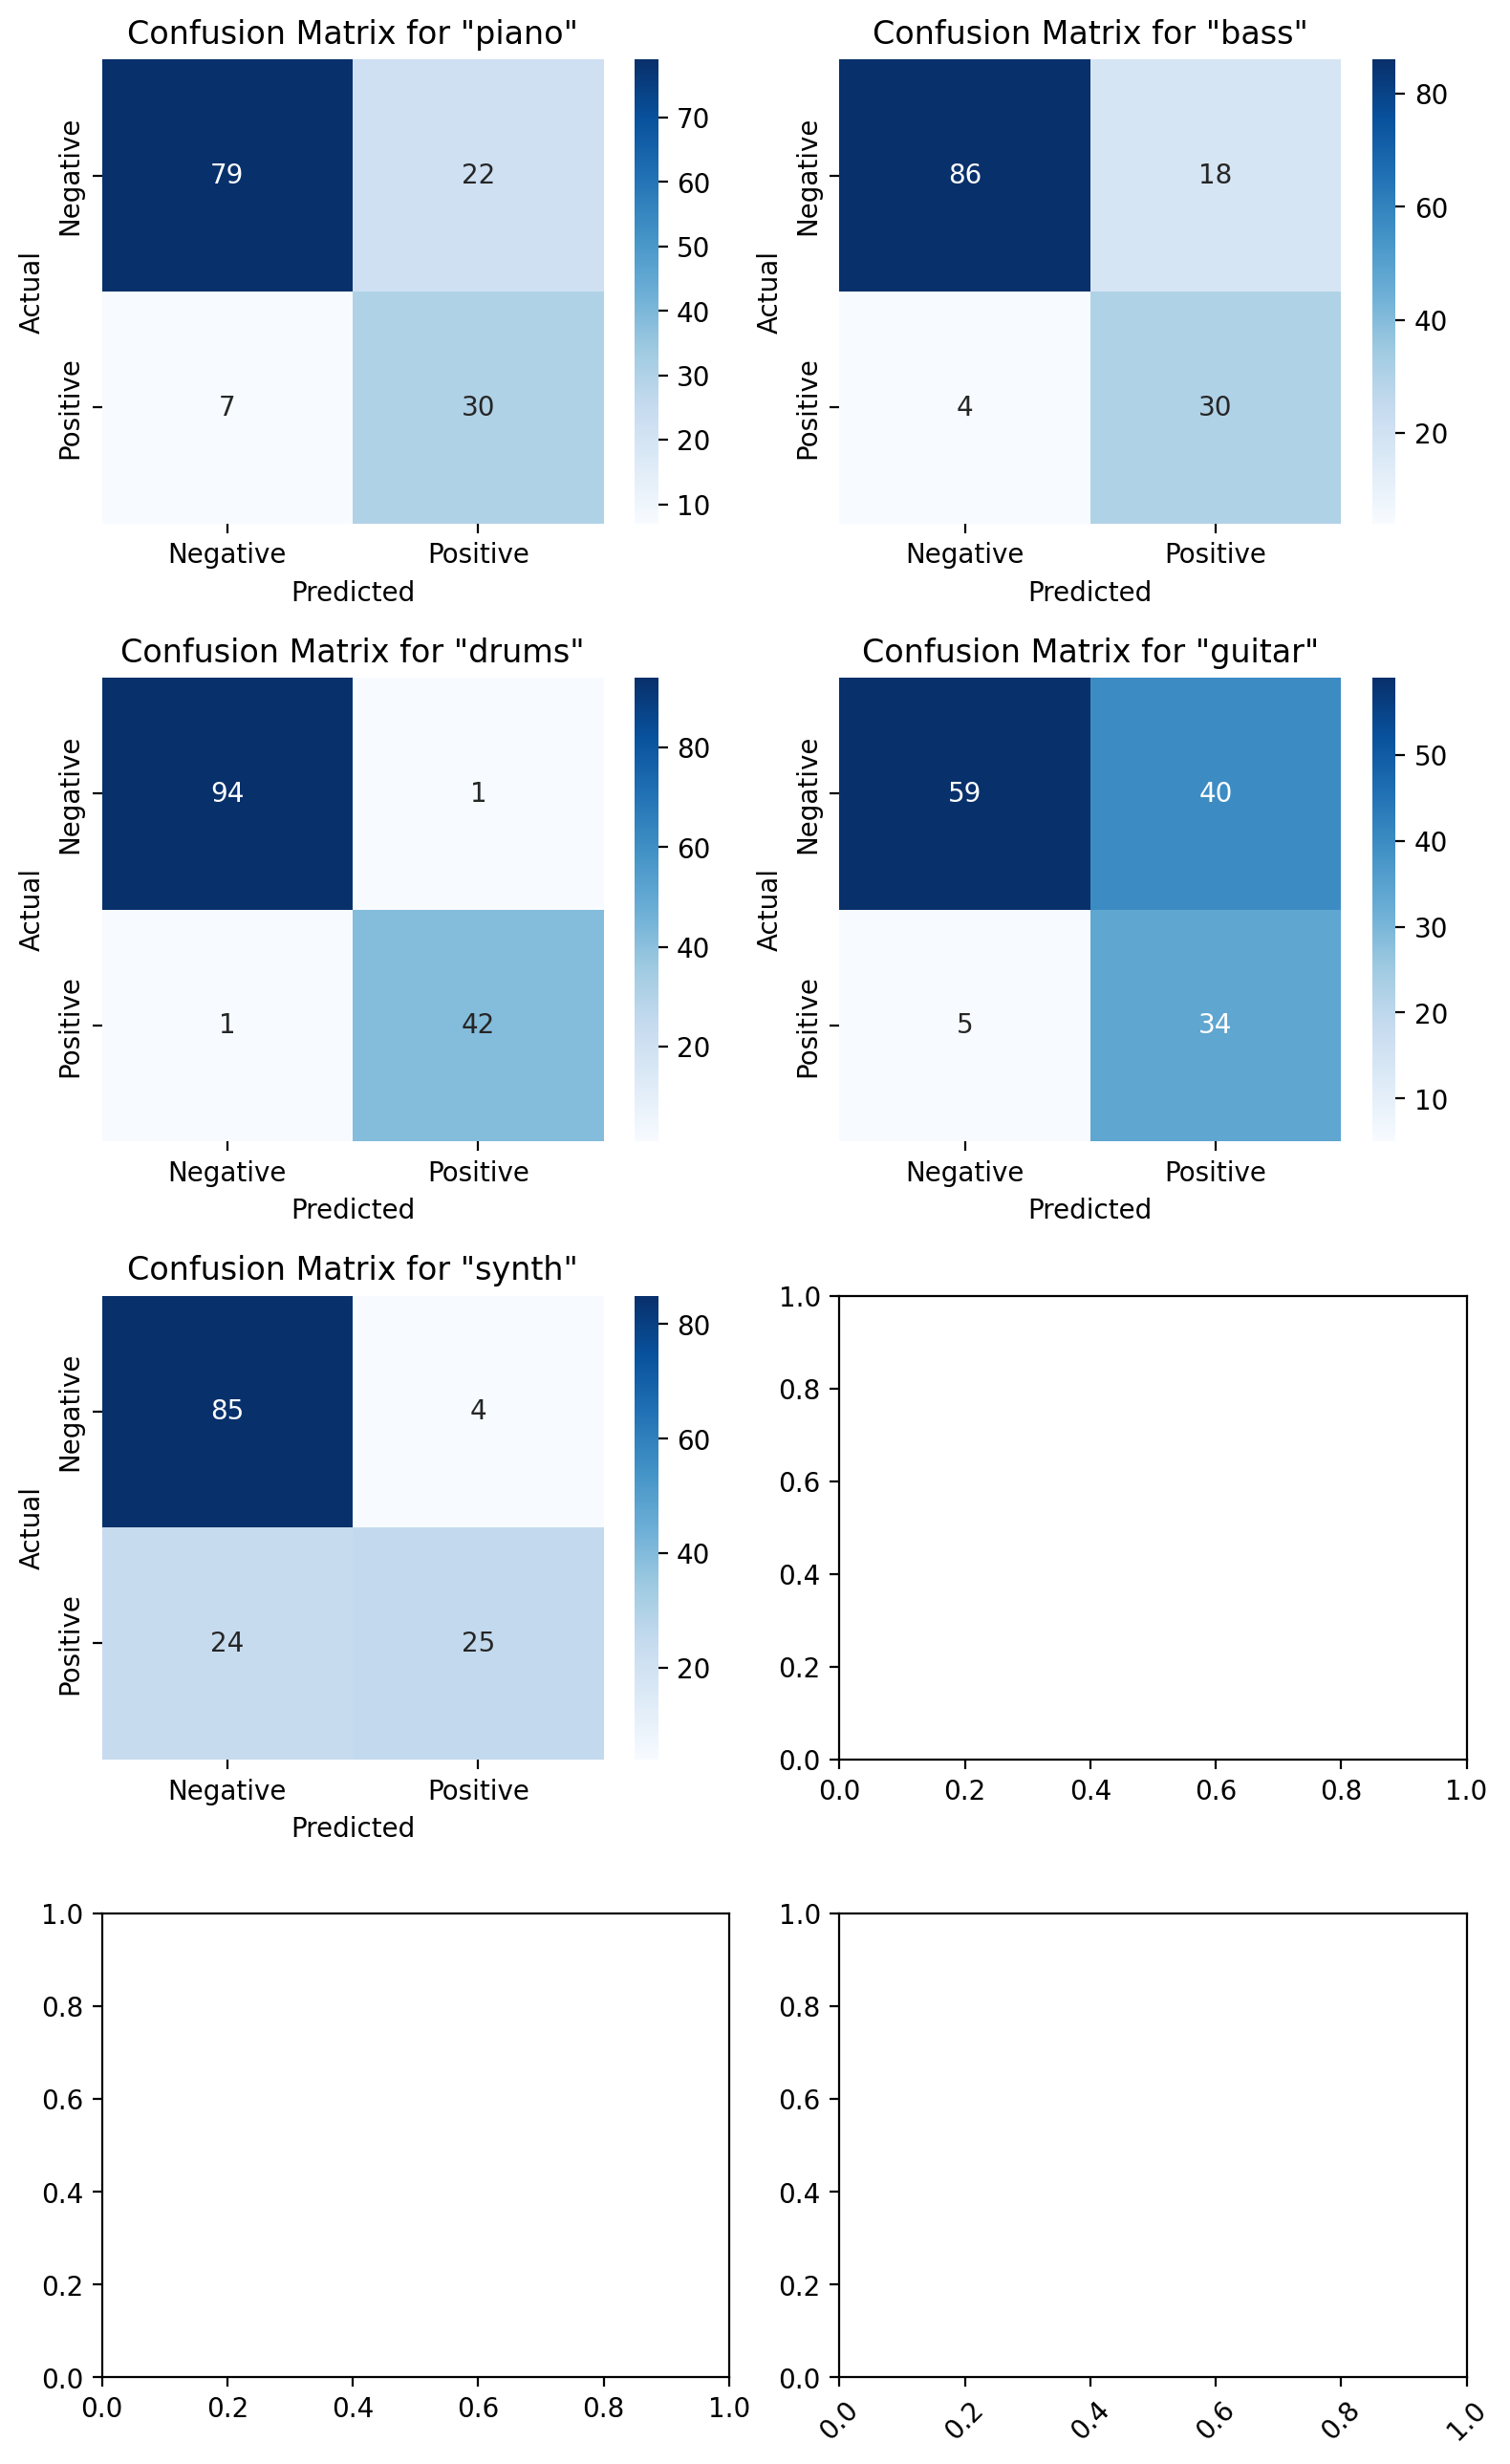

In [188]:
# Plot confusion matrix heatmaps for each instrument
fig, axes = plt.subplots(4, 2, figsize=(8, 13))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 5: break
    sns.heatmap(
        cm[i].numpy(),
        annot=True,
        fmt='g',
        cmap='Blues',
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        ax=ax
    )
    plt.xticks(rotation=45)
    ax.set_title(f'Confusion Matrix for "{class_names[i]}"')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [180]:
train_accs = [0.756, 0.8, 0.816, 0.831, 0.842, 0.861, 0.859, 0.866, 0.884, 0.89, 0.898, 0.898, 0.905, 0.91, 0.917, 0.918, 0.927, 0.928, 0.935, 0.945, 0.952, 0.96]
val_accs = [0.513, 0.71, 0.697, 0.682, 0.734, 0.709, 0.685, 0.765, 0.776, 0.778, 0.749, 0.821, 0.743, 0.76, 0.71, 0.626, 0.813, 0.807, 0.731, 0.834, 0.815, 0.835]
val_losses = [0.886, 0.636, 0.549, 0.738, 0.822, 0.647, 0.972, 0.516, 0.835, 0.487, 0.72, 0.396, 0.881, 0.584, 1.093, 1.701, 0.499, 0.67, 0.912, 0.441, 0.568, 0.519]
train_losses = [0.490, 0.420, 0.384, 0.344, 0.329, 0.291, 0.288, 0.287, 0.251, 0.237, 0.222, 0.218, 0.208, 0.199, 0.183, 0.185, 0.167, 0.165, 0.152, 0.132, 0.116, 0.099]

Text(0, 0.5, 'MultilabelAccuracy')

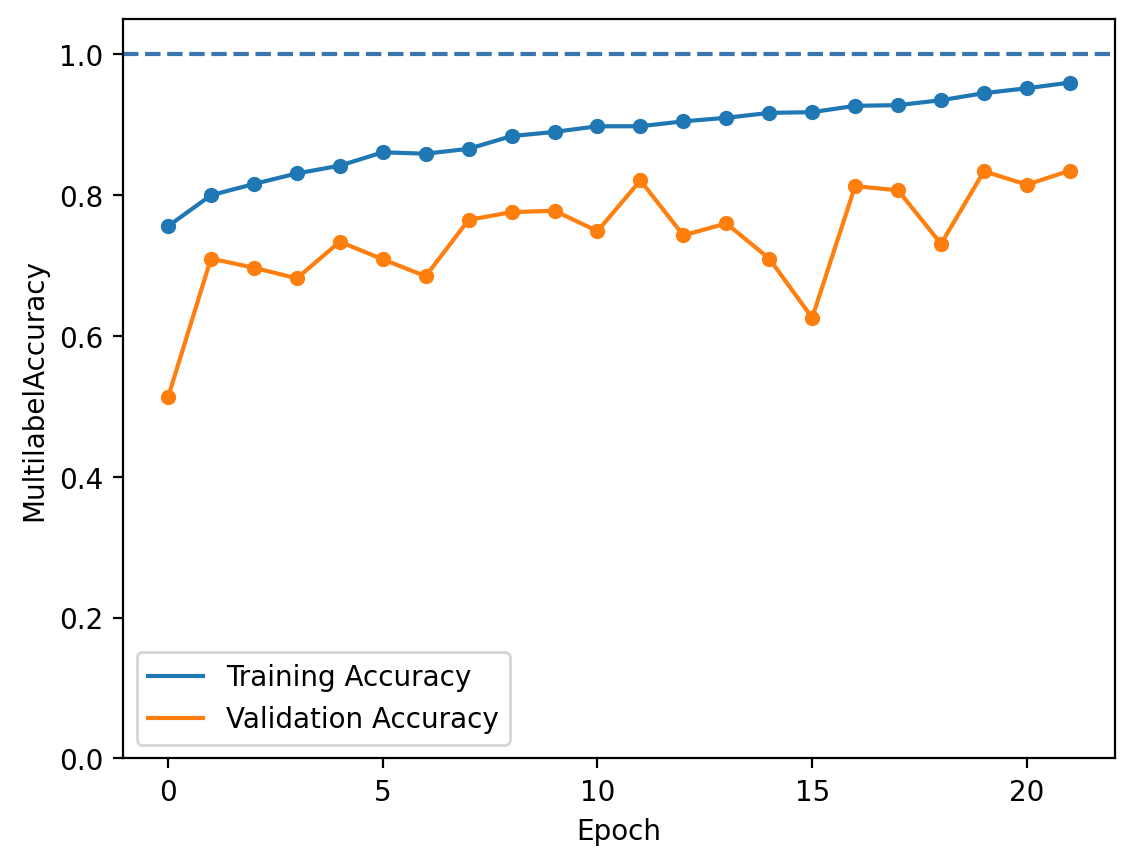

In [183]:
sns.lineplot(train_accs, markers="o", label="Training Accuracy")
sns.scatterplot(train_accs, markers="o")
sns.lineplot(val_accs, markers="o", label="Validation Accuracy")
sns.scatterplot(val_accs, markers="o")
plt.axhline(1, color='#3b75ae', linestyle='--')
plt.ylim(0, 1.05);
plt.xlabel("Epoch")
plt.ylabel("MultilabelAccuracy")

Text(0, 0.5, 'Loss')

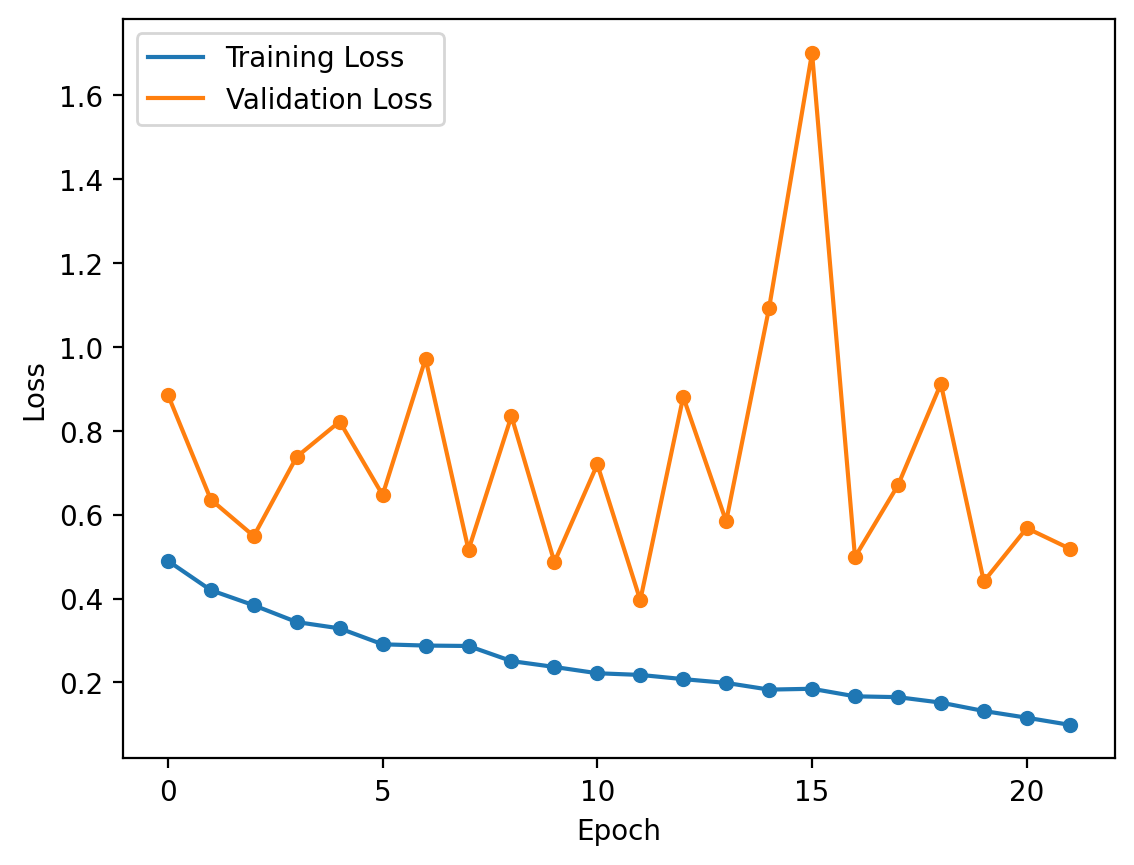

In [184]:
sns.lineplot(train_losses, markers="o", label="Training Loss")
sns.scatterplot(train_losses, markers="o")
sns.lineplot(val_losses, markers="o", label="Validation Loss")
sns.scatterplot(val_losses, markers="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.axhline(1, color='#3b75ae', linestyle='--')
# plt.ylim(0, 1.05);

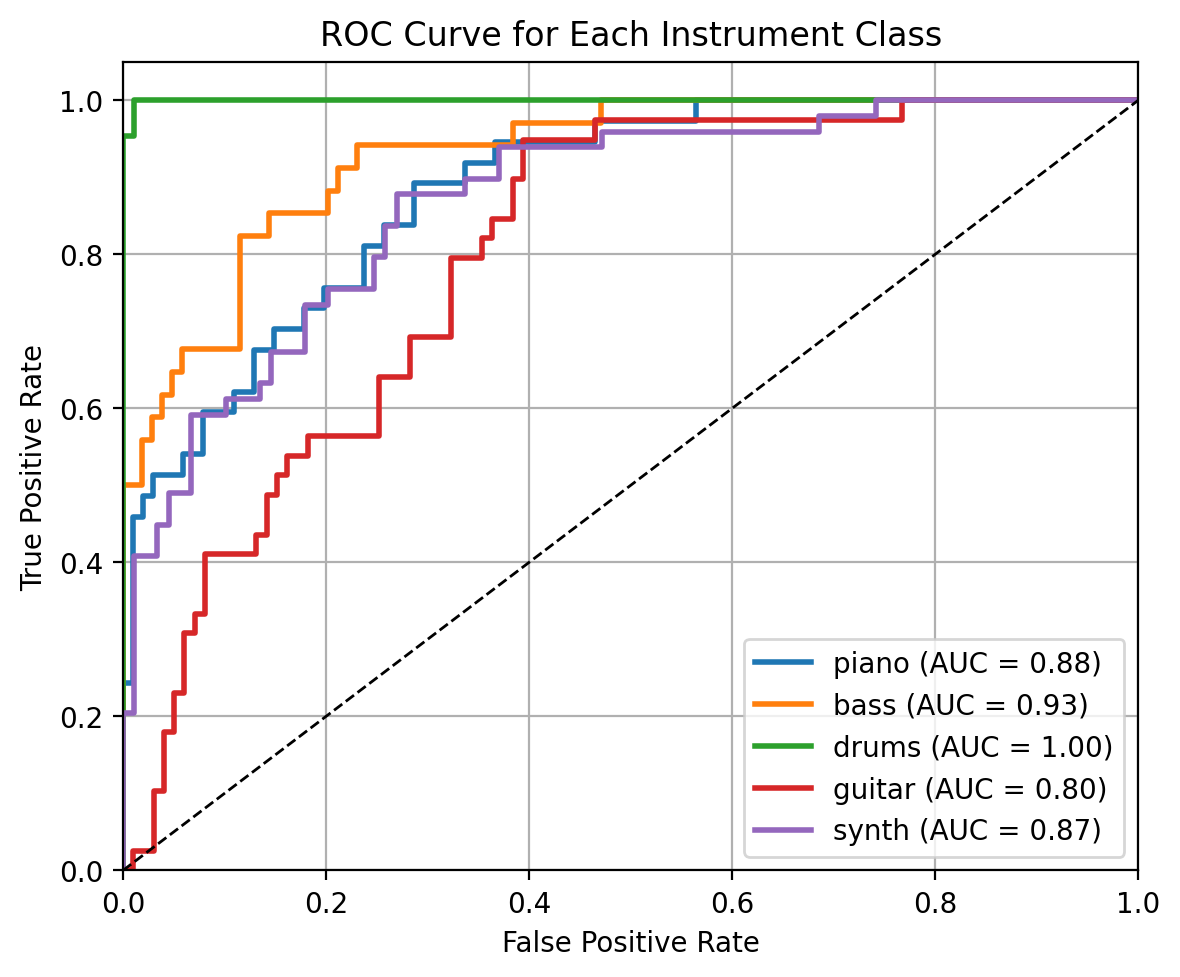

In [197]:
from sklearn.metrics import roc_curve, auc

# all_probs = torch.cat(all_probs).numpy()     # shape: [num_samples, num_classes]
# all_targets = torch.cat(all_targets).numpy() # same shape

fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_targets[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # random baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Instrument Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [191]:
auroc = test_auroc.compute()  # shape: [num_classes]
print("AUROC (per class):")
for i, score in enumerate(auroc):
    print(f"{class_names[i]}: {score:.3f}")

AUROC (per class):
piano: 0.872
bass: 0.921
drums: 1.000
guitar: 0.797
synth: 0.837
